## Libraries

In [1]:
import pandas as pd
import numpy as np
np.random.seed(2019)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import re
import sys
from collections import defaultdict

from scikitplot.estimators import plot_learning_curve
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier
import xgboost as xgb

from ml_metrics import rmsle, mae, mse
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score,r2_score, mean_absolute_error 

import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [27]:
train = pd.read_hdf('../input/diabetic_train.h5')
test = pd.read_hdf('../input/diabetic_test.h5')

## Basic model

In [28]:
def get_X_y(feats):
    X = train[ feats ].fillna(-1).values
    y = train['readmitted'].values
    
    return X, y

X, y = get_X_y(['admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed'])

In [29]:
cross_val_score(DummyClassifier(random_state=2019), X, y, scoring='accuracy', cv=3).mean()

0.7132613234092765

In [30]:
cross_val_score(DecisionTreeClassifier(max_depth=3, random_state=2019), X, y, scoring='accuracy', cv=3).mean()

0.8324407733502768

In [31]:
cross_val_score(RandomForestClassifier(max_depth=3, n_estimators=100, random_state=2019), X, y, scoring='accuracy', cv=3).mean()

0.8269038758282653

In [32]:
cross_val_score(xgb.XGBClassifier(max_depth=3, n_estimators=100, random_state=2019), X, y, scoring='accuracy', cv=3).mean()

0.8339535868808811

## New feats

In [40]:
def get_feats(df):
    black_list = ['id', 'readmitted']
    feats = df.select_dtypes(include=[np.number]).columns.values
    
    feats = [feat for feat in feats if feat not in black_list]
    return feats
    
def get_X_y(df, target='readmitted', verbose=False):
    feats = get_feats(df)
    if verbose: print(feats)
        
    X = df[ get_feats(df) ].values
    y = df[target].values
    
    return X, y

X, y = get_X_y(train)

In [41]:
cross_val_score(xgb.XGBClassifier(max_depth=3, n_estimators=100, random_state=2019), X, y, scoring='accuracy', cv=3).mean()

0.7154700311639587

## Feature engineering #1

In [46]:
# Leave top10 values, the rest to 'other'
top_diag_1 = list(train['diag_1'].value_counts().head(10).keys())

diag_1_norm = defaultdict(lambda: 'other', dict(zip(top_diag_1, top_diag_1)))
train['diag_1_norm'] = train['diag_1'].map(diag_1_norm)
# factorize
train['diag_1_norm_cat'] = train['diag_1_norm'].factorize()[0]


In [48]:
# diag_2
# Leave top10 values, the rest to 'other'
top_diag_2 = list(train['diag_2'].value_counts().head(10).keys())

diag_2_norm = defaultdict(lambda: 'other', dict(zip(top_diag_2, top_diag_2)))
train['diag_2_norm'] = train['diag_2'].map(diag_2_norm)
train['diag_2_norm_cat'] = train['diag_2_norm'].factorize()[0]

train['diag_2_norm_cat'].value_counts()

0     19221
1      2217
9      2119
5      2024
2      1586
3      1363
10     1038
4       993
6       856
8       843
7       791
Name: diag_2_norm_cat, dtype: int64

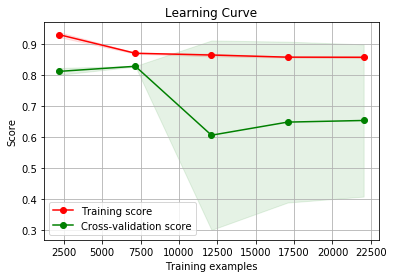

In [49]:
X, y = get_X_y(train)

cross_val_score(xgb.XGBClassifier(max_depth=3, n_estimators=100, random_state=2019), X, y, scoring='accuracy', cv=3).mean()
plot_learning_curve(xgb.XGBClassifier(max_depth=5, n_estimators=150, random_state=2019), X, y, cv=3);

In [51]:
feats

['encounter_id',
 'patient_nbr',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'diag_1_norm_cat']

In [ ]:
# Categorical features


In [52]:
# Numerical features
train.select_dtypes(include=[np.number]).columns.values

array(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'readmitted', 'id', 'diag_1_norm_cat',
       'diag_2_norm_cat', 'diag_3_norm_cat'], dtype=object)